In [1]:
import os
import random
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

SOURCE_DIR = "../../data2"
DEST_DIR = os.path.join(SOURCE_DIR, "processed224")

# ignorer "5" = disgust
CLASSES = ['0','1','2','3','4','6']

IMG_SIZE = (224, 224)
MAX_IMAGES_PER_CLASS = 15000
FEAR_TARGET = 10000 
VAL_LIMIT = 500 
test_run = True     


In [ ]:
from PIL import Image

# Chemin de l'image d'entrée
input_path = r"../../data2/train/1/00a7b5dec8a800dbc72e8738dd6a40e7d49fa7859b443ccda82a4116.jpg"
# Chemin de l'image redimensionnée (tu peux modifier le nom)
output_path = r"../../data2/img64.jpg"

# Ouvrir l'image
img = Image.open(input_path)

# Redimensionner l'image à 64x64 pixels
img_resized = img.resize((64, 64))

# Sauvegarder l'image redimensionnée
img_resized.save(output_path)

print("Image redimensionnée sauvegardée dans", output_path)


FileNotFoundError: [Errno 2] No such file or directory: '../../data2/train/1/100a7b5dec8a800dbc72e8738dd6a40e7d49fa7859b443ccda82a4116.jpg'

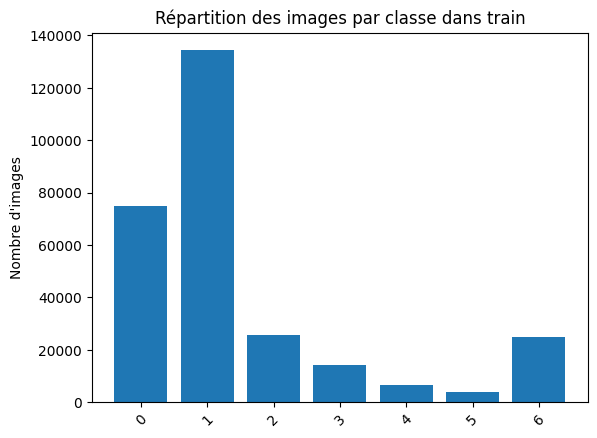

{'0': 74873, '1': 134415, '2': 25459, '3': 14090, '4': 6378, '5': 3803, '6': 24882}


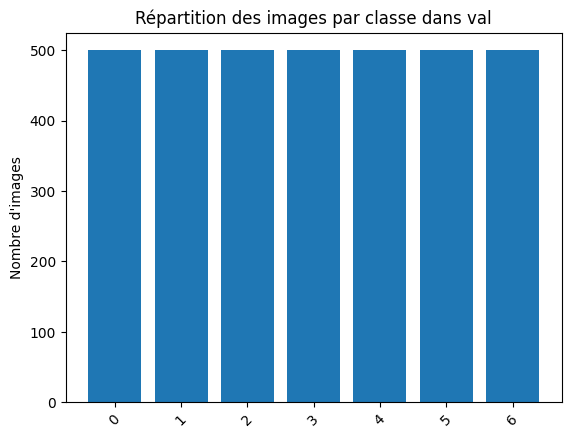

{'0': 500, '1': 500, '2': 500, '3': 500, '4': 500, '5': 500, '6': 500}


In [2]:
data_path = "../../data2/train"
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name))) for class_name in os.listdir(data_path)}

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe dans train")
plt.show()

print(class_counts)

data_path = "../../data2/val"
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name))) for class_name in os.listdir(data_path)}

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe dans val")
plt.show()

print(class_counts)

In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

def augment_image(img):
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, 0)  # Ajouter une dimension batch
    augmented = data_augmentation(img_tensor)  # Appliquer l'augmentation
    augmented_img = augmented[0].numpy()  # Convertir en NumPy
    return np.clip(augmented_img, 0, 255).astype(np.uint8)

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    return img



In [4]:
def process_split(split="train"):
    """Traite un dataset (train ou val) en appliquant prétraitement et augmentation si nécessaire."""
    src_path = os.path.join(SOURCE_DIR, split)
    dst_path = os.path.join(DEST_DIR, split)
    os.makedirs(dst_path, exist_ok=True)

    for class_name in CLASSES:
        class_src = os.path.join(src_path, class_name)
        class_dst = os.path.join(dst_path, class_name)
        os.makedirs(class_dst, exist_ok=True)

        all_images = os.listdir(class_src)
        random.shuffle(all_images)

        # Si mode test, ne prend que 10 images
        if test_run:
            all_images = all_images[:10]
        else:
            # Limiter le nombre d'images à MAX_IMAGES_PER_CLASS (sauf exceptions)
            if len(all_images) > MAX_IMAGES_PER_CLASS:
                all_images = all_images[:MAX_IMAGES_PER_CLASS]

        # Sauvegarde des images prétraitées
        count_saved = 0
        for img_name in tqdm(all_images, desc=f"{split} | classe {class_name}", leave=False):
            img_path = os.path.join(class_src, img_name)
            try:
                img_array = preprocess_image(img_path)
                out_name = f"{class_name}_{count_saved}.jpg"
                out_path = os.path.join(class_dst, out_name)
                cv2.imwrite(out_path, cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR))
                count_saved += 1
            except:
                pass  # Ignorer les images corrompues

        # Data augmentation spécifique pour certaines classes
        if not test_run and split == "train":
            # **Classe "4" (fear) doit atteindre FEAR_TARGET**
            if class_name == '4' and count_saved < FEAR_TARGET:
                while count_saved < FEAR_TARGET:
                    rand_img = random.choice(all_images)
                    img_path = os.path.join(class_src, rand_img)
                    try:
                        img_array = preprocess_image(img_path)
                        aug_array = augment_image(img_array)
                        out_name = f"{class_name}_{count_saved}.jpg"
                        out_path = os.path.join(class_dst, out_name)
                        cv2.imwrite(out_path, cv2.cvtColor(aug_array, cv2.COLOR_RGB2BGR))
                        count_saved += 1
                    except:
                        pass

            # **Classe "3" (surprise) doit atteindre MAX_IMAGES_PER_CLASS**
            if class_name == '3' and count_saved < MAX_IMAGES_PER_CLASS:
                while count_saved < MAX_IMAGES_PER_CLASS:
                    rand_img = random.choice(all_images)
                    img_path = os.path.join(class_src, rand_img)
                    try:
                        img_array = preprocess_image(img_path)
                        aug_array = augment_image(img_array)
                        out_name = f"{class_name}_{count_saved}.jpg"
                        out_path = os.path.join(class_dst, out_name)
                        cv2.imwrite(out_path, cv2.cvtColor(aug_array, cv2.COLOR_RGB2BGR))
                        count_saved += 1
                    except:
                        pass

        # **Limiter val/4/ à 500 images**
        if not test_run and split == "val" and class_name == '4':
            saved_images = os.listdir(class_dst)
            if len(saved_images) > VAL_LIMIT:
                # Supprimer les images en excès
                for img_name in saved_images[VAL_LIMIT:]:
                    os.remove(os.path.join(class_dst, img_name))

In [5]:
test_run = True
process_split("train")
process_split("val")


In [ ]:
test_run = False
process_split("train")
process_split("val")


: 

In [ ]:
import os
import random
import cv2
import numpy as np
import tensorflow as tf

# Si ce n'est pas déjà fait, assure-toi d'avoir ces variables définies
SOURCE_DIR = "../../data2"  # dossier source contenant "train" et "val"
DEST_DIR = os.path.join(SOURCE_DIR, "processed264")
CLASSES = ['0','1','2','3','4','6']
IMG_SIZE = (264, 264)
MAX_IMAGES_PER_CLASS = 15000  # cible pour toutes les classes sauf pour '4'
FEAR_TARGET = 10000           # cible pour la classe '4'

# Fonctions existantes
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

def augment_image(img):
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, 0)
    augmented = data_augmentation(img_tensor)
    augmented_img = augmented[0].numpy()
    augmented_img = np.clip(augmented_img, 0, 255).astype(np.uint8)
    return augmented_img

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    return img

# Nouvelle fonction pour compléter les dossiers "3" et "4"
def augment_missing(split="train", classes_to_augment=['3', '4']):
    src_path = os.path.join(SOURCE_DIR, split)
    dst_path = os.path.join(DEST_DIR, split)
    
    for class_name in classes_to_augment:
        # Définir la cible selon la classe
        if class_name == '3':
            target = MAX_IMAGES_PER_CLASS  # 15 000 images
        elif class_name == '4':
            target = FEAR_TARGET           # 10 000 images
        
        class_dst = os.path.join(dst_path, class_name)
        os.makedirs(class_dst, exist_ok=True)
        
        # Nombre d'images déjà présentes dans le dossier processed
        existing_images = os.listdir(class_dst)
        count_saved = len(existing_images)
        print(f"Classe {class_name}: {count_saved} images existantes, cible = {target}")
        
        # Récupérer la liste des images sources (non traitées) dans le dossier original
        class_src = os.path.join(src_path, class_name)
        source_images = os.listdir(class_src)
        if len(source_images) == 0:
            print(f"Aucune image source trouvée pour la classe {class_name} dans {class_src}")
            continue
        
        # Tant que le nombre d'images est inférieur à la cible, appliquer de l'augmentation
        while count_saved < target:
            # Pioche aléatoirement une image source
            img_name = random.choice(source_images)
            img_path = os.path.join(class_src, img_name)
            try:
                img_array = preprocess_image(img_path)
                aug_array = augment_image(img_array)
                out_name = f"{class_name}_{count_saved}.jpg"
                out_path = os.path.join(class_dst, out_name)
                cv2.imwrite(out_path, cv2.cvtColor(aug_array, cv2.COLOR_RGB2BGR))
                count_saved += 1
                if count_saved % 100 == 0:
                    print(f"Classe {class_name}: {count_saved} images générées")
            except Exception as e:
                print(f"Erreur sur {img_path}: {e}")

# Exécuter le processus uniquement sur le split souhaité (par exemple, "train")
augment_missing(split="train", classes_to_augment=['3', '4'])


Classe 3: 14090 images existantes, cible = 15000
Classe 3: 14100 images générées
Classe 3: 14200 images générées
Classe 3: 14300 images générées
Classe 3: 14400 images générées
Classe 3: 14500 images générées
Classe 3: 14600 images générées
Classe 3: 14700 images générées
Classe 3: 14800 images générées
Classe 3: 14900 images générées
Classe 3: 15000 images générées
Classe 4: 8000 images existantes, cible = 10000
Classe 4: 8100 images générées
Classe 4: 8200 images générées
Classe 4: 8300 images générées
Classe 4: 8400 images générées
Classe 4: 8500 images générées
Classe 4: 8600 images générées
Classe 4: 8700 images générées
Classe 4: 8800 images générées
Classe 4: 8900 images générées
Classe 4: 9000 images générées
Classe 4: 9100 images générées
Classe 4: 9200 images générées
Classe 4: 9300 images générées
Classe 4: 9400 images générées
Classe 4: 9500 images générées
Classe 4: 9600 images générées
Classe 4: 9700 images générées
Classe 4: 9800 images générées
Classe 4: 9900 images gén